In [1]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy as np

- What is a spectral index?
    - A spectral index is a mathematical equation that is applied on the various
spectral bands of an image per pixel
- The most common mathematical formula is the normalized difference
(ND), i.e. the difference between the two selected bands normalized by
their sum


- The Normalized Difference Vegetation Index (NDVI) quantifies vegeta-
tion by measuring the difference between near-infrared (NIR, which vege-
tation strongly reflects) and red light (RED, which vegetation absorbs)
    -  The result of this formula generates a value between -1 and +1: if a pixel
has low reflectance (or low values) in the red channel and high reflectance
in the NIR channel, this will yield a high NDVI value (and vice versa
    - Negative values of NDVI (values approaching -1) correspond to water
    - Values close to zero (-0.1 to 0.1) generally correspond to barren areas of
rock, sand, or snow
    - Values greater than 0.2 are vegetation (the higher the value the healthier/-
denser the vegetation)



In [2]:
from pystac_client import Client
from odc.stac import load
import odc.geo

In [3]:
client = Client.open("https://earth-search.aws.element84.com/v1") 

# ID of the collection
collection = "sentinel-2-l2a"

# Geometry of AOI
geometry = {
    "coordinates": [
        [
            [12.57952494681641,42.173988781433145],
            [12.58948130667969,42.12880960265559],
            [12.639263105996097,42.135302116134895],
            [12.610423994667972,42.18047666209273],
            [12.57952494681641,42.173988781433145]
            
        ]
    ],
    "type": "Polygon",
}

here there are different ways to select the images 

In [ ]:
# Date range
date_range = "2023-01-10/2023-01-20"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_range
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

In [6]:
# additional filters as per metadata 
filters = {
    #"eo:cloud_cover":{"lt":0.2},
    "s2:vegetation_percentage": {"gt": 25}
}
date_YYMM = "2023-01"
# run pystac client search to see available dataset 
search = client.search(collections=[collection], intersects=geometry , query=filters ,datetime=date_YYMM) #bbox=tas_bbox
#spit out data as GeoJSON dictionary
#print(search.item_collection_as_dict())
# loop through each item
#for item in search.items_as_dicts():
 #   print(item)

This is where odc-stac will be helpful, it converts data into xarray Dataset


In [7]:
#load the data in xarray format
data = load(search.items() ,geopolygon=geometry,groupby="solar_day", chunks={})

In [8]:
# The scaling factor  is used to convert these digital number values (integers) to actual physical reflectance values. 
def ReverseScalingFactor(band,prop):
  return search.item_collection_as_dict()['features'][0]['assets'][band]['raster:bands'][0][prop]


data["nir"] = data["nir"] * ReverseScalingFactor('nir', 'scale')
data["red"] = data["red"] * ReverseScalingFactor('red', 'scale')
data["blue"] = data["blue"] * ReverseScalingFactor('blue', 'scale')
data["green"] = data["green"] * ReverseScalingFactor('green', 'scale')

# i proceed with creating an aggregated median image 
median_img = data.median(dim='time')
#print(median_img)

# Relevant surfaces of the earth

- Earth surface
- Geoid (irregular surface)
- Earth ellipsoid (purely geometric surface)

## Geoid shape
- it defined with respect to the chosen ellipsoid;
- Given a point on the topological surface we have:
    - Orthometric heigth H, the height from the geoid to the point
    - Geoid ondulation N, the height from the ellipsoid to the geoid
- we can compute the Geodetic heigth h, as the height from the ellipsoid to the actual point on the topological surface (h = H + N). 
- Therefore, h and N are dependent on the chosen ellipsoid;

## Measuring these distances
How to get these measures?
- H is measured traditionally
- h is about the previous sum
- N is modeled


Ellipsoid:
- GRS80
- WGS84; 

- (WGS84) is reference 
frame for Global 
Positioning Systems
Geoidapproximation: 
global (WGS84) vs. local (NAD83)

## What is a reference frame?
- Reference frame (datum) - set of rules to 
uniquely define point positions

- Reference frame for positioning on the Earth 
associated with:
    - a chosen ellipsoid (a, b) placed in
    - a chosen position with respect to the geoid, i.e. the body of the Earth

## What are the coordinates systems:
- In a chosen datum (reference frame) point 
positions can be represented using different 
coordinate systems:
    - (1) Global Cartesian coordinates (X,Y,Z)
    - (2a) Ellipsoidal coordinates (f, l, h)
    - (2b) Orthometric height (H)
    - (3) Projected (Cartographic) coordinates 
(E,N) onto a map



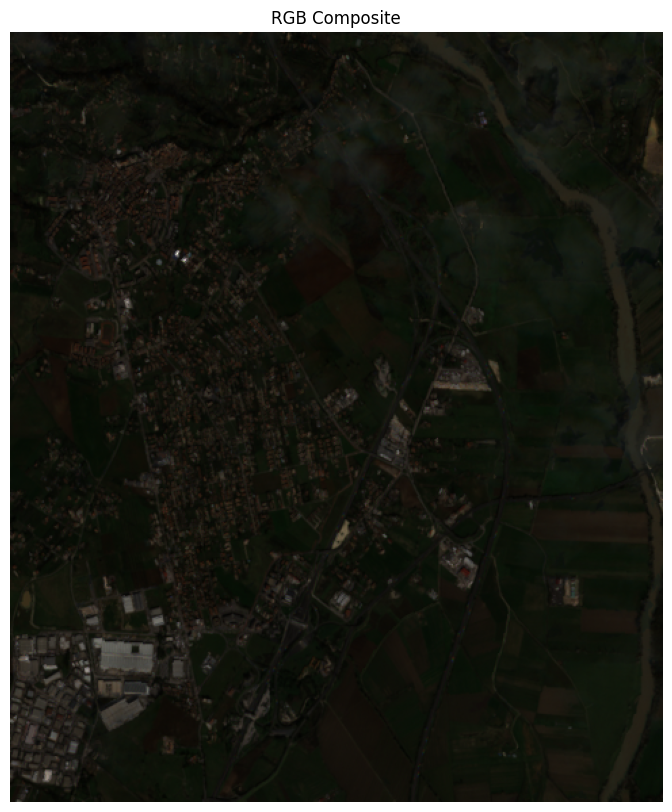

In [9]:
RED = median_img["red"]
BLUE = median_img["blue"]
GREEN = median_img["green"]
bands = [RED,GREEN,BLUE]
rgb_image = np.dstack(bands)
plt.figure(figsize=(10, 10))
plt.title(f'RGB Composite')
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

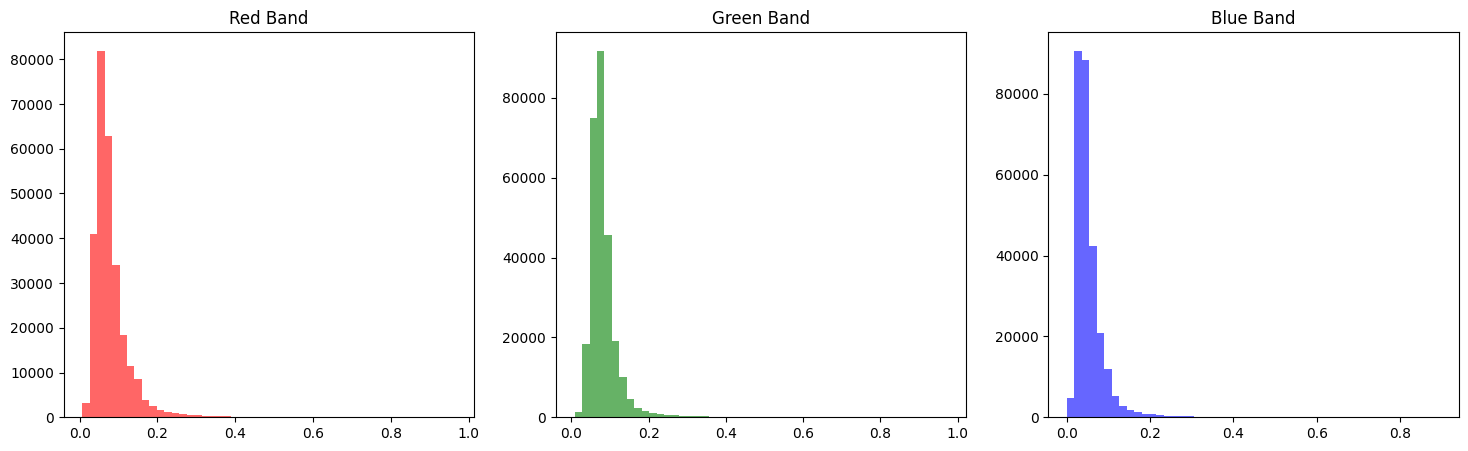

In [18]:
red_band = rgb_image[:, :, 0]
green_band = rgb_image[:, :, 1]
blue_band = rgb_image[:, :, 2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.hist(red_band.ravel(), bins=50, color='red', alpha=0.6)
ax1.set_title('Red Band')

ax2.hist(green_band.ravel(), bins=50, color='green', alpha=0.6)
ax2.set_title('Green Band')

ax3.hist(blue_band.ravel(), bins=50, color='blue', alpha=0.6)
ax3.set_title('Blue Band')

plt.show()

Let's compute the NDVI

In [11]:
RED = median_img["red"]
NIR = median_img["nir"]

numerator = NIR - RED
denominator = NIR + RED
NDVI = numerator / denominator
print(NDVI)


<xarray.DataArray (y: 569, x: 482)> Size: 2MB
dask.array<truediv, shape=(569, 482), dtype=float64, chunksize=(569, 482), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 4.673e+06 4.673e+06 ... 4.667e+06 4.667e+06
  * x            (x) float64 4kB 3.001e+05 3.001e+05 ... 3.049e+05 3.049e+05
    spatial_ref  int32 4B 32633


In [12]:
print(NDVI.shape)

(569, 482)


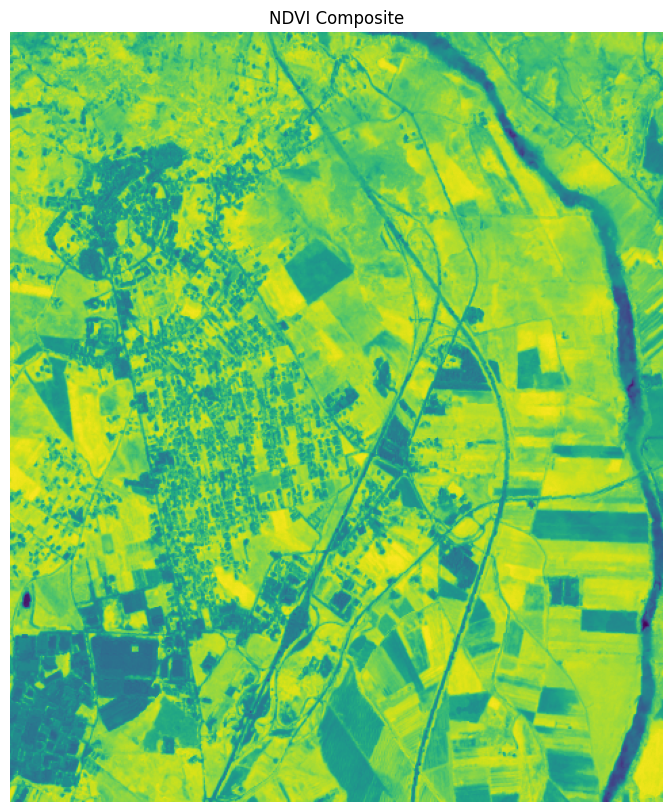

In [14]:
plt.figure(figsize=(10, 10))
plt.title(f'NDVI Composite')
plt.imshow(NDVI)
plt.axis('off')
plt.show()

In [15]:
odc.geo.xr.write_cog(NDVI,fname='ndvi.tiff',  overwrite=True)
#img = rasterio.open("./ndvi.tiff")
#show(img)

PosixPath('ndvi.tiff')

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


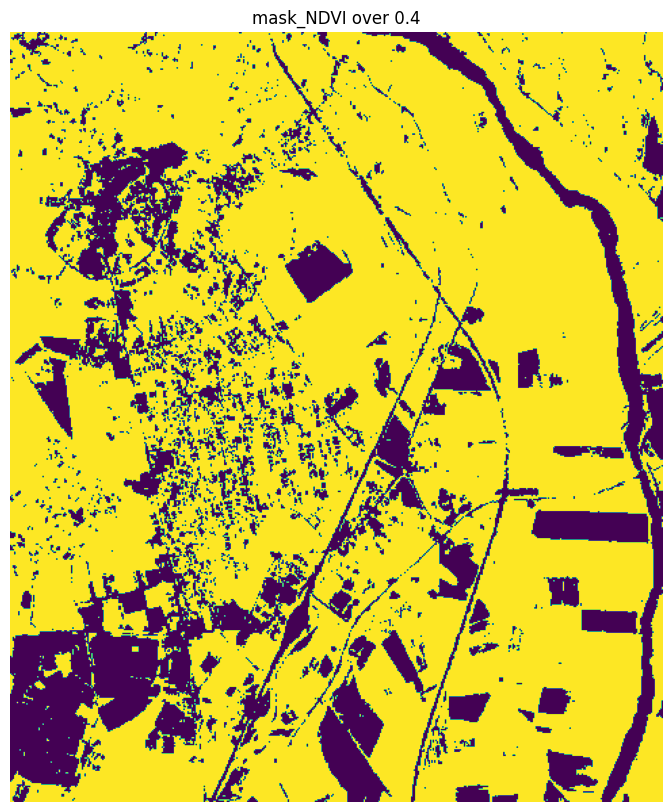

In [16]:
# Apply the mask: NDVI > 0.4 to find healthy vegetation
mask_NDVI = NDVI > 0.4
plt.figure(figsize=(10, 10))
plt.title(f'mask_NDVI over 0.4')
plt.imshow(mask_NDVI)
plt.axis('off')
plt.show()